Forecasting energy consumption can play an important role in an organization to improve the rate of energy consumption by making the right decisions at the right time.

With the significant growth of the population, more energy is consumed. According to research and statistics, energy consumption is expected to be in considerable proportions. For example, statistics from China show that energy consumption was around 28% in 2011, they predicted it could reach around 35% in 2020, so by analyzing the increasing rate, they can take better decisions at the right time to control the rate of energy consumption.

There are so many methods to predict the rate of energy consumption. The main methods depend on historical data. We can use the historical data time series to create prediction models.

By using the historical data we can predict future energy consumption. Here, we will use the electric power consumption data of one household.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing

In [2]:
df = pd.read_csv('household_power_consumption.txt', sep=';', 
                 parse_dates={'dt' : ['Date', 'Time']}, infer_datetime_format=True, 
                 low_memory=False, na_values=['nan','?'], index_col='dt')

df.shape

(2075259, 7)

In [3]:
df.isnull().sum()

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

We have so many null values in the dataset, we will fill these null values with the mean values:

In [4]:
df = df.fillna(df.mean())

Let’s have a look at the data more closely by visualizing it:

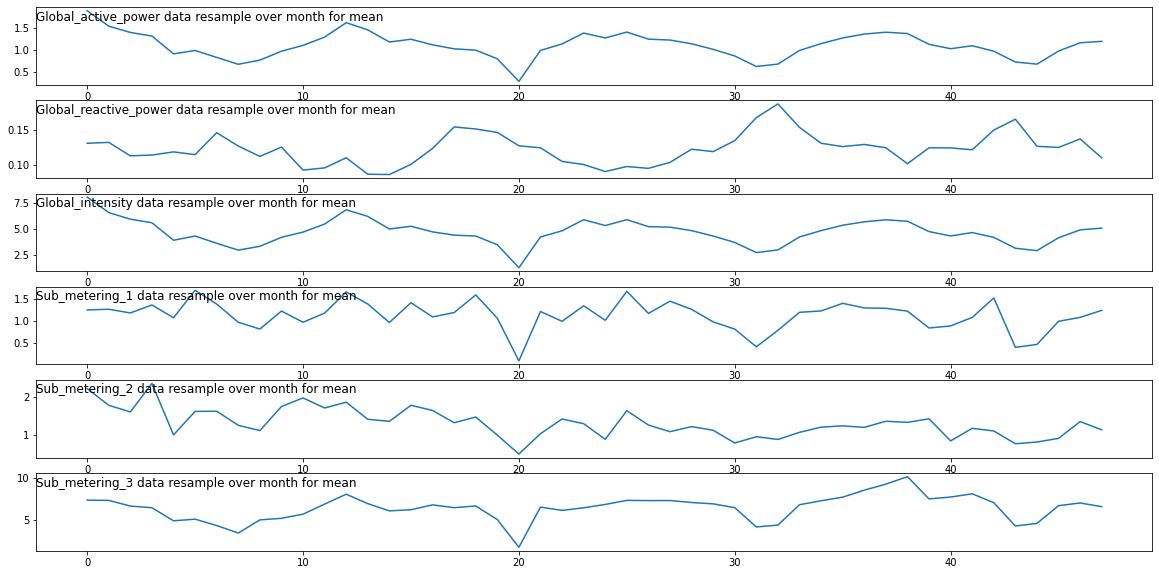

In [5]:
import matplotlib.pyplot as plt

i = 1
cols=[0, 1, 3, 4, 5, 6]
plt.figure(figsize=(20, 10))
for col in cols:
    plt.subplot(len(cols), 1, i)
    plt.plot(df.resample('M').mean().values[:, col])
    plt.title(df.columns[col] + ' data resample over month for mean', y=0.75, loc='left')
    i += 1
plt.show()

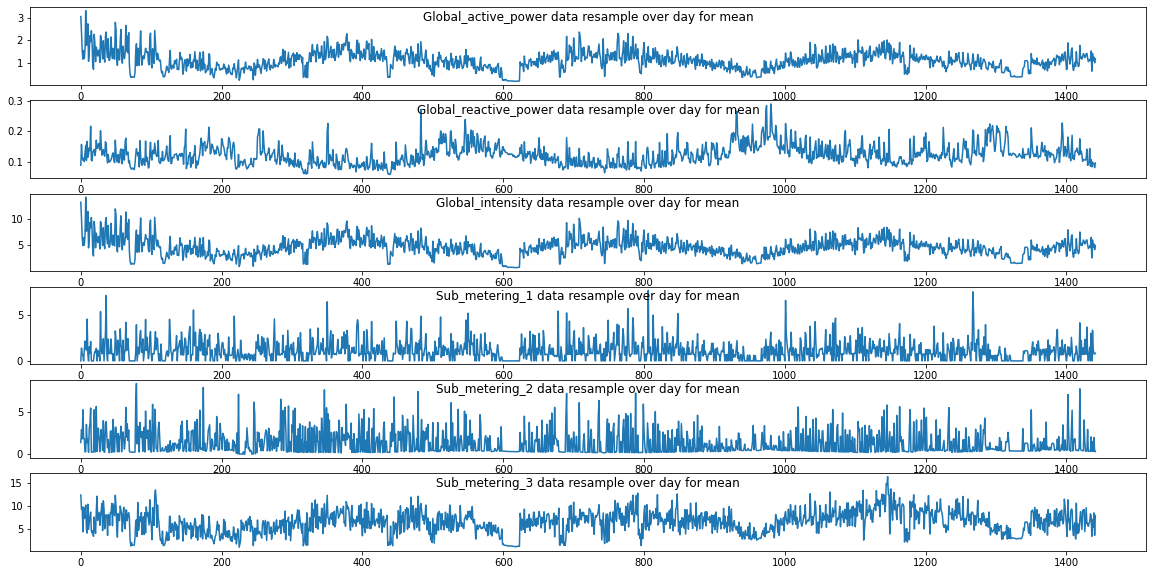

In [6]:
i = 1
cols=[0, 1, 3, 4, 5, 6]
plt.figure(figsize=(20, 10))
for col in cols:
    plt.subplot(len(cols), 1, i)
    plt.plot(df.resample('D').mean().values[:, col])
    plt.title(df.columns[col] + ' data resample over day for mean', y=0.75, loc='center')
    i += 1
plt.show()

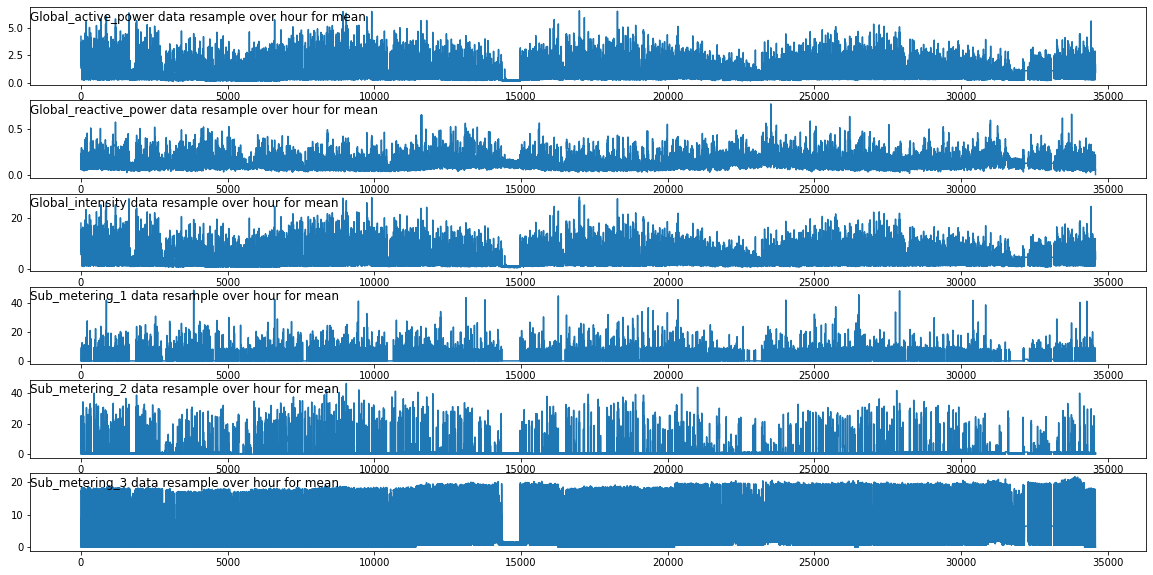

In [7]:
i = 1
cols=[0, 1, 3, 4, 5, 6]
plt.figure(figsize=(20, 10))
for col in cols:
    plt.subplot(len(cols), 1, i)
    plt.plot(df.resample('H').mean().values[:, col])
    plt.title(df.columns[col] + ' data resample over hour for mean', y=0.75, loc='left')
    i += 1
plt.show()

1. Resampling by month, date or time is very important because it has a great interaction as expected (changing the periodicity of the system).
2. Therefore, if we process all the original data, the run time will be very expensive, but if we process data with large timescale samples (e.g., monthly), it will affect the predictability of the model.
3. From observation, we can see it is relatively reasonable to resample the data per hour.

### Using the LSTM Model

For energy consumption prediction, we will use the LSTM model because it is very well suited for large time-series data. we’ll start this step by preparing a helper function to frame the problem:

In [8]:
df = df[['Global_active_power', 'Global_reactive_power', 'Voltage',
       'Global_intensity', 'Sub_metering_2', 'Sub_metering_1','Sub_metering_3']]

In [9]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    dff = pd.DataFrame(data)
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
        cols.append(dff.shift(-i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    for i in range(0, n_out):
        cols.append(dff.shift(-i))
        if i==0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1)) for j in range(n_vars)]        
        agg = pd.concat(cols, axis=1)
        agg.columns = names
        if dropnan:
            agg.dropna(inplace=True)
        return agg

To reduce the time of the calculation and get the results fast, we will resample the dataset:

In [10]:
df_resample = df.resample('h').mean() 
df_resample.shape

(34589, 7)

So we will have 7 input variables and 1 output variable. Let’s split and prepare the data from the LSTM model:

In [12]:
from sklearn.preprocessing import MinMaxScaler

values = df_resample.values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [13]:
reframed = series_to_supervised(scaled, 1, 1)
r = list(range(df_resample.shape[1]+1, 2*df_resample.shape[1]))
reframed.drop(reframed.columns[r], axis=1, inplace=True)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var1(t)
0,0.545045,0.103358,0.335501,0.541487,0.144652,0.0,0.782676,0.636816
1,0.509006,0.110073,0.283802,0.502152,0.030869,0.0,0.774169,0.545045
2,0.488550,0.096987,0.315987,0.481110,0.000000,0.0,0.778809,0.509006
3,0.455597,0.099010,0.434417,0.449904,0.008973,0.0,0.798917,0.488550
4,0.322555,0.072536,0.495847,0.323529,0.002872,0.0,0.205723,0.455597


In [14]:
# Data spliting into train and test data series. Only 4000 first data points are selected for traing purpose.
values = reframed.values
n_train_time = 4000
train = values[:n_train_time, :]
test = values[n_train_time:, :]
train_x, train_y = train[:, :-1], train[:, -1]
test_x, test_y = test[:, :-1], test[:, -1]
train_x = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
test_x = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))

Let’s use the LSTM model for energy consumption prediction. Below are the parameters that we will use in the LSTM model:

1. 100 neurons in the first visible layer
2. dropout 10%
3. `1` neuron in the output layer to predict Global_active_power
4. The entry form will be a step with 7 features
5. The loss function mean_squared_error and Adam’s efficient version of stochastic gradient descent
6. The model will be suitable for 50 training periods with a lot size of 70.

In [15]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from sklearn.metrics import mean_squared_error,r2_score
import matplotlib.pyplot as plt
import numpy as np

In [16]:
model = Sequential()
model.add(LSTM(100, input_shape=(train_x.shape[1], train_x.shape[2])))
model.add(Dropout(0.1))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [17]:
# Network fitting
history = model.fit(train_x, train_y, epochs=50, batch_size=70, validation_data=(test_x, test_y), verbose=2, shuffle=False)

Epoch 1/50
58/58 - 17s - loss: 0.0261 - val_loss: 0.0103
Epoch 2/50
58/58 - 1s - loss: 0.0145 - val_loss: 0.0098
Epoch 3/50
58/58 - 1s - loss: 0.0136 - val_loss: 0.0097
Epoch 4/50
58/58 - 1s - loss: 0.0130 - val_loss: 0.0095
Epoch 5/50
58/58 - 1s - loss: 0.0126 - val_loss: 0.0094
Epoch 6/50
58/58 - 1s - loss: 0.0123 - val_loss: 0.0093
Epoch 7/50
58/58 - 1s - loss: 0.0120 - val_loss: 0.0093
Epoch 8/50
58/58 - 1s - loss: 0.0120 - val_loss: 0.0093
Epoch 9/50
58/58 - 1s - loss: 0.0120 - val_loss: 0.0092
Epoch 10/50
58/58 - 1s - loss: 0.0119 - val_loss: 0.0092
Epoch 11/50
58/58 - 1s - loss: 0.0118 - val_loss: 0.0092
Epoch 12/50
58/58 - 1s - loss: 0.0118 - val_loss: 0.0091
Epoch 13/50
58/58 - 1s - loss: 0.0117 - val_loss: 0.0092
Epoch 14/50
58/58 - 1s - loss: 0.0118 - val_loss: 0.0091
Epoch 15/50
58/58 - 1s - loss: 0.0117 - val_loss: 0.0091
Epoch 16/50
58/58 - 1s - loss: 0.0117 - val_loss: 0.0091
Epoch 17/50
58/58 - 1s - loss: 0.0117 - val_loss: 0.0091
Epoch 18/50
58/58 - 1s - loss: 0.0116 -

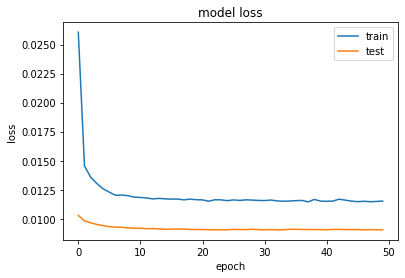

In [18]:
# Loss history plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [19]:
size = df_resample.shape[1]

In [20]:
# Prediction test
yhat = model.predict(test_x)
test_x = test_x.reshape((test_x.shape[0], size))

In [21]:
# invert scaling for prediction
inv_yhat = np.concatenate((yhat, test_x[:, 1-size:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

In [22]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_x[:, 1-size:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

In [23]:
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.612


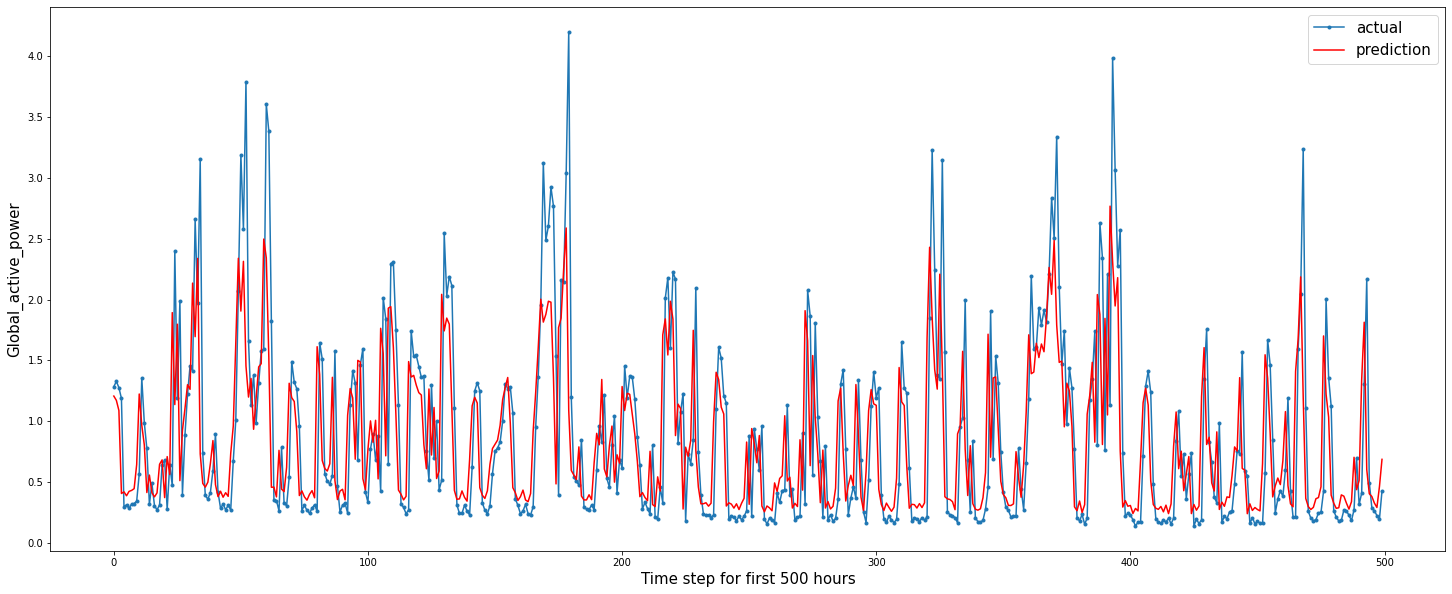

In [24]:
aa=[x for x in range(500)]
plt.figure(figsize=(25,10)) 
plt.plot(aa, inv_y[:500], marker='.', label="actual")
plt.plot(aa, inv_yhat[:500], 'r', label="prediction")
plt.ylabel(df.columns[0], size=15)
plt.xlabel('Time step for first 500 hours', size=15)
plt.legend(fontsize=15)
plt.show()